In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Geo_3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
summ_stats = []
for i in range(lfp.shape[0]):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(1000, 176, 384)


In [9]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [10]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:12,  1.05s/it]

Training Loss: 5957909.152112961 Validation Loss: 519023.2692871094


  4%|▎         | 11/300 [00:11<04:58,  1.03s/it]

Training Loss: 732819.813501358 Validation Loss: 531678.9104442596


  7%|▋         | 21/300 [00:21<04:53,  1.05s/it]

Training Loss: 490065.7553534508 Validation Loss: 463444.07514953613


 10%|█         | 31/300 [00:32<04:41,  1.05s/it]

Training Loss: 399408.40772628784 Validation Loss: 387459.2285308838


 14%|█▎        | 41/300 [00:42<04:23,  1.02s/it]

Training Loss: 333491.81145596504 Validation Loss: 343200.68173217773


 17%|█▋        | 51/300 [00:53<04:22,  1.05s/it]

Training Loss: 271126.1342725754 Validation Loss: 274789.428604126


 20%|██        | 61/300 [01:03<04:09,  1.04s/it]

Training Loss: 232183.95316648483 Validation Loss: 253272.51509857178


 24%|██▎       | 71/300 [01:14<03:57,  1.04s/it]

Training Loss: 193450.02810883522 Validation Loss: 188197.73620986938


 27%|██▋       | 81/300 [01:24<03:48,  1.04s/it]

Training Loss: 163550.46271419525 Validation Loss: 146068.71184921265


 30%|███       | 91/300 [01:34<03:38,  1.05s/it]

Training Loss: 140170.88974690437 Validation Loss: 108289.6626086235


 34%|███▎      | 101/300 [01:45<03:27,  1.04s/it]

Training Loss: 119481.54974746704 Validation Loss: 108785.58359718323


 37%|███▋      | 111/300 [01:55<03:17,  1.04s/it]

Training Loss: 105320.68722808361 Validation Loss: 78563.63628768921


 40%|████      | 121/300 [02:05<03:03,  1.02s/it]

Training Loss: 96866.14409184456 Validation Loss: 61366.71066856384


 44%|████▎     | 131/300 [02:16<02:55,  1.04s/it]

Training Loss: 85403.26249575615 Validation Loss: 56337.41963386536


 47%|████▋     | 141/300 [02:25<02:35,  1.02it/s]

Training Loss: 80636.38162821531 Validation Loss: 45389.51286792755


 50%|█████     | 151/300 [02:36<02:34,  1.04s/it]

Training Loss: 77826.92873573303 Validation Loss: 41585.05308532715


 54%|█████▎    | 161/300 [02:45<02:00,  1.15it/s]

Training Loss: 74287.24309301376 Validation Loss: 36631.15924048424


 57%|█████▋    | 171/300 [02:55<02:10,  1.01s/it]

Training Loss: 70094.24787378311 Validation Loss: 33964.8679664135


 60%|██████    | 181/300 [03:05<02:03,  1.04s/it]

Training Loss: 66153.86442220211 Validation Loss: 31584.4199719429


 64%|██████▎   | 191/300 [03:15<01:53,  1.04s/it]

Training Loss: 61871.547773599625 Validation Loss: 30710.37867486477


 67%|██████▋   | 201/300 [03:26<01:43,  1.05s/it]

Training Loss: 57477.29817408323 Validation Loss: 29594.967370390892


 70%|███████   | 211/300 [03:36<01:32,  1.04s/it]

Training Loss: 54300.53348436952 Validation Loss: 29655.442996501923


 74%|███████▎  | 221/300 [03:47<01:22,  1.04s/it]

Training Loss: 51258.903400063515 Validation Loss: 29522.06968688965


 77%|███████▋  | 231/300 [03:57<01:12,  1.05s/it]

Training Loss: 48345.727625370026 Validation Loss: 29308.113932073116


 80%|████████  | 241/300 [04:08<01:01,  1.04s/it]

Training Loss: 46216.33806908131 Validation Loss: 29567.959007680416


 84%|████████▎ | 251/300 [04:18<00:50,  1.02s/it]

Training Loss: 44350.343084812164 Validation Loss: 29695.674909591675


 87%|████████▋ | 261/300 [04:28<00:40,  1.04s/it]

Training Loss: 42201.26384973526 Validation Loss: 30094.255755662918


 90%|█████████ | 271/300 [04:39<00:30,  1.04s/it]

Training Loss: 40643.75638759136 Validation Loss: 30166.336724996567


 94%|█████████▎| 281/300 [04:49<00:19,  1.04s/it]

Training Loss: 39242.270848184824 Validation Loss: 30456.09424829483


 97%|█████████▋| 291/300 [04:59<00:09,  1.05s/it]

Training Loss: 37986.51211440563 Validation Loss: 29952.640973329544


100%|██████████| 300/300 [05:09<00:00,  1.03s/it]


In [11]:
from sklearn.metrics import r2_score

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()
print("R2: {}".format(r2_score(y, output)))
print(output.shape)
print(y.shape)

R2: 0.0030778171331307855
(128, 3)
(128, 3)


<IPython.core.display.Javascript object>


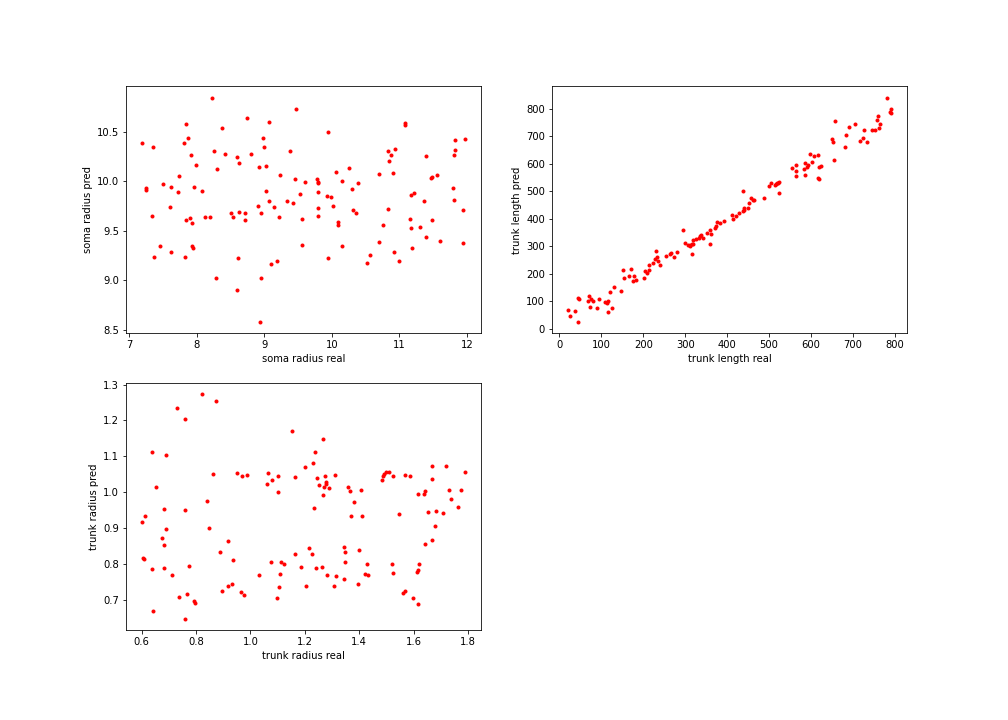

In [12]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))
#inf_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']

ax_s = plt.subplot(221)
ax_s.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_s.set_xlabel('soma radius real')
ax_s.set_ylabel('soma radius pred')

ax_t = plt.subplot(222)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('trunk length real')
ax_t.set_ylabel('trunk length pred')

ax_t = plt.subplot(223)
ax_t.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_t.set_xlabel('trunk radius real')
ax_t.set_ylabel('trunk radius pred')

# ax_t = plt.subplot(324)
# ax_t.scatter(y[:,3], output[:,3], c='red', marker='.')
# ax_t.set_xlabel('dendrite radius real')
# ax_t.set_ylabel('dendrite radius pred')

# ax_t = plt.subplot(325)
# ax_t.scatter(y[:,4], output[:,4], c='red', marker='.')
# ax_t.set_xlabel('tuft radius real')
# ax_t.set_ylabel('tuft radius pred')

# ax_t = plt.subplot(326)
# ax_t.scatter(y[:,5], output[:,5], c='red', marker='.')
# ax_t.set_xlabel('dendrite length real')
# ax_t.set_ylabel('dendrite length pred')

plt.show()

<IPython.core.display.Javascript object>


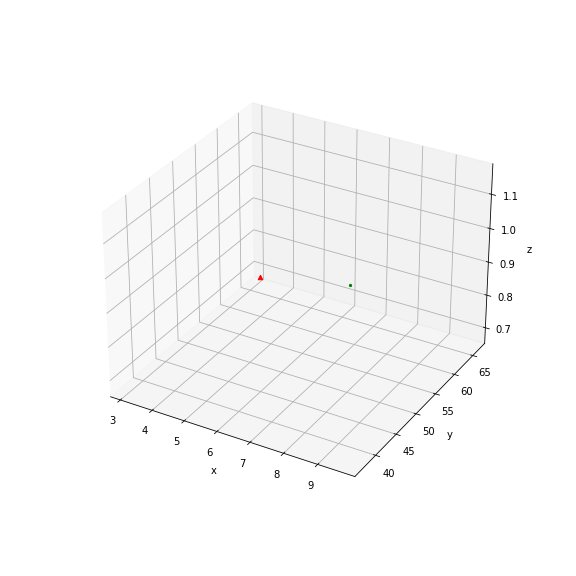

Text(0.5, 0, 'z')

In [7]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()